## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

### Import

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [6]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 평가
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    # 결과 출력
    print()
    print("--- Model Performance ---")
    print(f"Model Accuracy: {accuracy}")
    print(f"Model F1 Score: {f1}")
    print(f"Model AUC: {auc}")
    
    # 혼동 행렬 출력
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    return y_pred, y_pred_proba

### Data Load

In [7]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_54.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_54.csv')

DI_train = pd.read_csv('../data/DI_train_dataset_54.csv')
DI_test = pd.read_csv('../data/DI_test_dataset_54.csv')

In [8]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

In [9]:
print(f"IVF_X shape: {IVF_X.shape}")
print(f"IVF_test shape: {IVF_test.drop('ID', axis=1).shape}")

print(f"DI_X shape: {DI_X.shape}")
print(f"DI_test shape: {DI_test.drop('ID', axis=1).shape}")

IVF_X shape: (250052, 77)
IVF_test shape: (87891, 77)
DI_X shape: (6289, 31)
DI_test shape: (2176, 31)


### 인코딩 

In [10]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "특정_시술_유형",
    "배란_유도_유형",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "채취_해동_차이",
    "해동_혼합_차이",
    "혼합_이식_차이",
    "이식_해동_차이"
]

In [11]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "특정_시술_유형",
    "정자_기증자_나이"
]

In [12]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [13]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

# 모델 리스트
models = {
    "LightGBM": LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=42, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(n_estimators=500, learning_rate=0.05, random_state=42, verbose=0),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42)
}

# 모델 학습 및 평가
for name, model in models.items():
    model.fit(IVF_X_train, IVF_y_train)
    y_pred_prob = model.predict_proba(IVF_X_test)[:, 1]
    auc_score = roc_auc_score(IVF_y_test, y_pred_prob)
    print(f"{name} AUC Score: {auc_score:.4f}")

    # Calibrated Classifier 적용
    calibrated_model = CalibratedClassifierCV(estimator=model, cv=5)
    calibrated_model.fit(IVF_X_train, IVF_y_train)
    calibrated_y_pred_prob = calibrated_model.predict_proba(IVF_X_test)[:, 1]
    calibrated_auc_score = roc_auc_score(IVF_y_test, calibrated_y_pred_prob)
    print(f"{name} (Calibrated) AUC Score: {calibrated_auc_score:.4f}")

LightGBM AUC Score: 0.7387
LightGBM (Calibrated) AUC Score: 0.7392
XGBoost AUC Score: 0.7389
XGBoost (Calibrated) AUC Score: 0.7390
CatBoost AUC Score: 0.7399
CatBoost (Calibrated) AUC Score: 0.7397


c:\Users\juneh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier AUC Score: 0.7119


In [ ]:
# 앙상블 모델 (Soft Voting)
ensemble_model = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'
)
ensemble_model.fit(IVF_X_train, IVF_y_train)
ensemble_y_pred_prob = ensemble_model.predict_proba(IVF_X_test)[:, 1]
ensemble_auc_score = roc_auc_score(IVF_y_test, ensemble_y_pred_prob)
print(f"Ensemble Model AUC Score: {ensemble_auc_score:.4f}")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import numpy as np

Epoch [1/10], Loss: 0.6068
Epoch [2/10], Loss: 0.5938
Epoch [3/10], Loss: 0.5236
Epoch [4/10], Loss: 0.4187
Epoch [5/10], Loss: 0.3343
Epoch [6/10], Loss: 0.3343
Epoch [7/10], Loss: 0.2240
Epoch [8/10], Loss: 0.3789
Epoch [9/10], Loss: 0.5225
Epoch [10/10], Loss: 0.5277
IVF CNN AUC Score: 0.7367
Epoch [1/10], Loss: 0.4123
Epoch [2/10], Loss: 0.1370
Epoch [3/10], Loss: 0.6371
Epoch [4/10], Loss: 0.6595
Epoch [5/10], Loss: 0.3994
Epoch [6/10], Loss: 0.1506
Epoch [7/10], Loss: 0.5877
Epoch [8/10], Loss: 0.4946
Epoch [9/10], Loss: 0.4582
Epoch [10/10], Loss: 0.2637
DI CNN AUC Score: 0.6969

--- Combined Model Performance ---
Model Accuracy: 0.7483664592638827
Model F1 Score: 0.15253235236155818
Model AUC: 0.7387359546360572


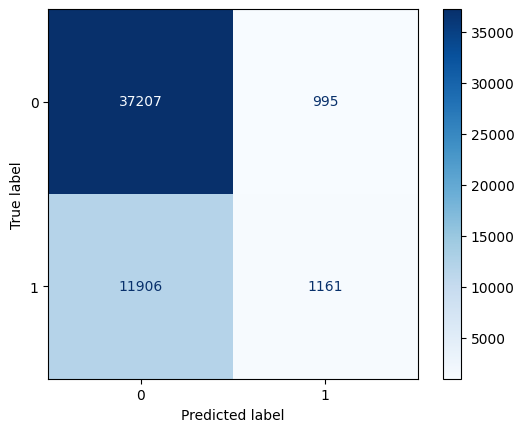

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch 기반 CNN 모델 정의
class CNN(nn.Module):
    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((input_size // 2 // 2) * 64, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

# 데이터 변환 함수
def prepare_data(X_train, X_test, y_train, y_test):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

    X_train_cnn = X_train_tensor.unsqueeze(1)
    X_test_cnn = X_test_tensor.unsqueeze(1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    return X_train_cnn, X_test_cnn, y_train_tensor, y_test_tensor, train_loader

# 모델 학습 함수
def train_model(model, train_loader, num_epochs=10, lr=0.0001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, X_test_cnn, y_test):
    model.eval()
    with torch.no_grad():
        y_pred_proba = model(X_test_cnn).cpu().numpy()
        y_pred = (y_pred_proba > 0.5).astype(int)
        auc = roc_auc_score(y_test, y_pred_proba)
        return y_pred, y_pred_proba, auc

# IVF 데이터 준비 및 모델 학습
X_train_cnn, X_test_cnn, y_train_tensor, y_test_tensor, train_loader = prepare_data(IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test)
cnn_model = CNN(input_size=IVF_X_train.shape[1]).to(device)
train_model(cnn_model, train_loader)
IVF_y_pred, IVF_y_pred_proba, IVF_auc = evaluate_model(cnn_model, X_test_cnn, IVF_y_test)
print(f"IVF CNN AUC Score: {IVF_auc:.4f}")

# DI 데이터 준비 및 모델 학습
X_train_cnn, X_test_cnn, y_train_tensor, y_test_tensor, train_loader = prepare_data(DI_X_train, DI_X_test, DI_y_train, DI_y_test)
cnn_model = CNN(input_size=DI_X_train.shape[1]).to(device)
train_model(cnn_model, train_loader)
DI_y_pred, DI_y_pred_proba, DI_auc = evaluate_model(cnn_model, X_test_cnn, DI_y_test)
print(f"DI CNN AUC Score: {DI_auc:.4f}")

# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred.flatten(), index=IVF_y_test.index), pd.Series(DI_y_pred.flatten(), index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba.flatten(), index=IVF_y_test.index), pd.Series(DI_y_pred_proba.flatten(), index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Combined Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

.